In [ ]:
import torch
import torch.nn as nn

# from torchsummary import summary
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# from torch_summary import summary
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import time
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    roc_curve,
)


In [34]:
df = pd.read_csv("data/processed_data.csv", index_col=0, parse_dates=True)
df_train = df[:"2024-07-01 01:00:00"]
df_val = df["2024-07-01 02:00:00":"2025-01-01 01:00:00"]
df_test = df["2025-01-01 02:00:00":]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_train.drop(columns=["y"]))
df_train.loc[:, df_train.columns != "y"] = scaled_features
scaled_features = scaler.transform(df_val.drop(columns=["y"]))
df_val.loc[:, df_val.columns != "y"] = scaled_features
scaled_features = scaler.transform(df_test.drop(columns=["y"]))
df_test.loc[:, df_test.columns != "y"] = scaled_features
df_train.head()

C:\Users\promb\AppData\Local\Temp\ipykernel_23096\2854313306.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6.49556993e-05 9.82308282e-06 7.14392348e-05 ... 4.21002287e-03
 3.76033026e-04 5.44764405e-04]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[:, df_train.columns != "y"] = scaled_features
C:\Users\promb\AppData\Local\Temp\ipykernel_23096\2854313306.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00173206 0.00114949 0.00131523 ... 0.00771562 0.05216576 0.00073065]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[:, df_train.columns != "y"] = scaled_features
C:\Users\promb\AppData\Local\Temp\ipykernel_23096\2854313306.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future er

,nvda_open,nvda_high,nvda_low,nvda_close,nvda_volume,amd_open,amd_high,amd_low,amd_close,amd_volume,...,stoch_d,macd,macd_signal,macd_hist,sma_14,atr_14,bb_20_upper,bb_20_lower,obv,obv_slope
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-03 09:00:00+00:00,0.100230,0.099461,0.101812,0.100132,0.000065,0.372579,0.368876,0.378170,0.372180,0.000114,...,0.581227,0.533387,0.526177,0.497413,0.099390,0.070185,0.095430,0.102604,0.081607,0.599255
2022-03-03 10:00:00+00:00,0.099999,0.099153,0.102006,0.100025,0.000010,0.372217,0.368816,0.379990,0.372059,0.000024,...,0.581601,0.532478,0.526616,0.494376,0.099553,0.063981,0.095352,0.103126,0.081606,0.569791
2022-03-03 11:00:00+00:00,0.100022,0.099546,0.101998,0.100025,0.000071,0.371613,0.370551,0.380597,0.371577,0.000253,...,0.577137,0.531630,0.526786,0.492059,0.099765,0.059999,0.095228,0.103677,0.081606,0.549950
2022-03-03 12:00:00+00:00,0.100115,0.099708,0.102107,0.100780,0.000246,0.373062,0.371508,0.381507,0.373688,0.000737,...,0.582843,0.532233,0.527051,0.492872,0.099925,0.056541,0.095166,0.104197,0.081616,0.532332
2022-03-03 13:00:00+00:00,0.099938,0.101294,0.102200,0.102406,0.001164,0.374631,0.373422,0.381398,0.377368,0.004397,...,0.622393,0.535574,0.527972,0.498554,0.100270,0.059970,0.095529,0.104220,0.081662,0.511631


In [35]:
df_train.tail()

,nvda_open,nvda_high,nvda_low,nvda_close,nvda_volume,amd_open,amd_high,amd_low,amd_close,amd_volume,...,stoch_d,macd,macd_signal,macd_hist,sma_14,atr_14,bb_20_upper,bb_20_lower,obv,obv_slope
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-06-28 19:00:00+00:00,0.872488,0.875665,0.869393,0.867553,0.063480,0.641965,0.639140,0.642701,0.642478,0.161446,...,0.326185,0.506846,0.525139,0.438691,0.894735,0.621850,0.867033,0.925605,0.949142,0.535600
2024-06-28 20:00:00+00:00,0.868944,0.869495,0.870891,0.870408,0.127142,0.642629,0.647515,0.651195,0.642478,0.295133,...,0.263549,0.497107,0.518271,0.431173,0.894538,0.605413,0.867119,0.925050,0.954130,0.592467
2024-06-28 21:00:00+00:00,0.868790,0.869572,0.875178,0.870562,0.004210,0.643836,0.638362,0.653076,0.643986,0.001221,...,0.238785,0.490028,0.511272,0.430047,0.894149,0.571571,0.867106,0.924428,0.954295,0.593741
2024-06-28 22:00:00+00:00,0.868867,0.869109,0.876188,0.869598,0.000376,0.643957,0.638302,0.653319,0.643111,0.000514,...,0.225672,0.483052,0.504191,0.429335,0.893498,0.533633,0.866990,0.923651,0.954280,0.596073
2024-06-28 23:00:00+00:00,0.868020,0.869109,0.876110,0.870178,0.000545,0.642870,0.638063,0.652833,0.642418,0.000536,...,0.221365,0.479084,0.497683,0.434293,0.892968,0.498747,0.867035,0.923408,0.954302,0.569716


In [36]:
df_val.tail()

,nvda_open,nvda_high,nvda_low,nvda_close,nvda_volume,amd_open,amd_high,amd_low,amd_close,amd_volume,...,stoch_d,macd,macd_signal,macd_hist,sma_14,atr_14,bb_20_upper,bb_20_lower,obv,obv_slope
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-31 20:00:00+00:00,0.954155,0.960198,0.956549,0.951687,0.039064,0.392554,0.390949,0.399830,0.392689,0.125758,...,0.140225,0.393599,0.449245,0.342678,0.988140,0.673285,0.974647,1.014908,0.860641,0.480830
2024-12-31 21:00:00+00:00,0.949917,0.962350,0.955450,0.952305,0.048483,0.392735,0.402093,0.397816,0.390156,0.115588,...,0.140435,0.380477,0.432777,0.348147,0.986804,0.692534,0.972143,1.013108,0.862543,0.502557
2024-12-31 22:00:00+00:00,0.950456,0.951405,0.958490,0.952266,0.000490,0.390200,0.388557,0.398313,0.389975,0.002400,...,0.126507,0.371723,0.417743,0.360546,0.985589,0.648358,0.969604,1.011650,0.862523,0.502335
2024-12-31 23:00:00+00:00,0.950302,0.950325,0.958024,0.951069,0.000235,0.390019,0.386642,0.398677,0.390156,0.001039,...,0.121746,0.364351,0.404150,0.373008,0.983397,0.605110,0.966696,1.010556,0.862514,0.502227
2025-01-01 00:00:00+00:00,0.949223,0.949862,0.957636,0.951686,0.000305,0.390381,0.386583,0.398799,0.390035,0.001355,...,0.107639,0.361495,0.392669,0.391275,0.981249,0.564091,0.966130,1.008613,0.862526,0.516138


In [39]:
df_test.tail()

,nvda_open,nvda_high,nvda_low,nvda_close,nvda_volume,amd_open,amd_high,amd_low,amd_close,amd_volume,...,stoch_d,macd,macd_signal,macd_hist,sma_14,atr_14,bb_20_upper,bb_20_lower,obv,obv_slope
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-06-30 18:00:00+00:00,1.131409,1.133134,1.134095,1.132940,0.021525,0.522751,0.518006,0.526817,0.518820,0.092069,...,0.758312,0.621006,0.652657,0.425174,1.157051,0.529178,1.118412,1.199502,0.865423,0.533097
2025-06-30 19:00:00+00:00,1.130869,1.138033,1.140541,1.133905,0.040266,0.518979,0.516869,0.525725,0.519906,0.162317,...,0.751291,0.614984,0.645328,0.427188,1.157327,0.522377,1.118165,1.199487,0.867002,0.551141
2025-06-30 20:00:00+00:00,1.131794,1.138102,1.127329,1.133287,0.109612,0.520005,0.527514,0.524451,0.518760,0.182311,...,0.723503,0.608049,0.637991,0.427125,1.157457,0.574684,1.118263,1.199732,0.862702,0.502024
2025-06-30 21:00:00+00:00,1.131178,1.138102,1.127329,1.133287,0.000332,0.518557,0.526079,0.524451,0.517674,0.001852,...,0.701637,0.601620,0.630756,0.428002,1.157586,0.623255,1.118276,1.200345,0.862702,0.502382
2025-06-30 22:00:00+00:00,1.131024,1.131398,1.139221,1.131204,0.000325,0.517772,0.513938,0.526392,0.517191,0.002254,...,0.674812,0.591815,0.622885,0.422501,1.156939,0.586085,1.116018,1.204370,0.862689,0.503544


In [40]:
df_test.shape

(1951, 57)

In [41]:
class WindowedDataset(Dataset):
    def __init__(self, df, feature_cols, window_size, target_col="y"):
        self.ws = int(window_size)
        df = df.dropna(subset=feature_cols + [target_col])

        X = df[feature_cols].to_numpy(dtype=np.float32)
        y = df[target_col].to_numpy(dtype=np.float32)

        # windows [i : i+ws] -> y[i+ws-1]
        N = len(X) - self.ws + 1
        self.X = np.stack([X[i : i + self.ws] for i in range(N)], axis=0)  # (N, ws, F)
        self.y = y[self.ws - 1 :]  # (N,)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).transpose(0, 1)  # (F, ws)
        y = torch.tensor(self.y[idx], dtype=torch.float32)  # scalar
        return x, y


def make_loader(dframe, batch_size, shuffle, feature_cols, window_size):
    ds = WindowedDataset(dframe, feature_cols, window_size, target_col="y")
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=True,
        pin_memory=torch.cuda.is_available(),
        num_workers=0,  # bump if you want
    )


# features = everything except the label `y`
feature_cols = [c for c in df.columns if c != "y"]
WINDOW = 64

train_loader = make_loader(df_train, batch_size=128, shuffle=True, feature_cols=feature_cols, window_size=WINDOW)
val_loader = make_loader(df_val, batch_size=256, shuffle=False, feature_cols=feature_cols, window_size=WINDOW)
test_loader = make_loader(df_test, batch_size=256, shuffle=False, feature_cols=feature_cols, window_size=WINDOW)

# quick sanity check
xb, yb = next(iter(train_loader))
print(xb.shape, yb.shape)  # (B, F, WINDOW) and (B,)


torch.Size([128, 56, 64]) torch.Size([128])


In [76]:
# class HybridGSRModel(nn.Module):
#     def __init__(self, n_features=5, lstm_units=50, cnn1_filters=64, cnn2_filters=32):
#         """
#         Initializes the PyTorch model based on the diagram.

#         :param n_features: The number of features at each time step (input channels).
#         :param lstm_units: The number of hidden units in each LSTM layer.
#         :param cnn1_filters: The number of filters for the 1st CNN branch.
#         :param cnn2_filters: The number of filters for the 2nd CNN branch.
#         """
#         super(HybridGSRModel, self).__init__()

#         # --- Branch 1: 1st Convolution Neural Network ---
#         # Keras 'padding=same' with kernel=3 is padding=1
#         self.cnn_branch1 = nn.Sequential(
#             nn.Conv1d(in_channels=n_features, out_channels=cnn1_filters, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2),  # P1
#             nn.Conv1d(in_channels=cnn1_filters, out_channels=cnn1_filters, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2),  # P2
#             nn.Conv1d(in_channels=cnn1_filters, out_channels=cnn1_filters, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2),  # P3
#             nn.Conv1d(in_channels=cnn1_filters, out_channels=cnn1_filters, kernel_size=3, padding=1),
#             nn.ReLU(),
#             # F1 output
#         )

#         # --- Branch 1: LSTM Network ---
#         # The input size for the LSTM is the number of filters from the CNN (cnn1_filters)
#         self.lstm_branch1 = nn.LSTM(
#             input_size=cnn1_filters,
#             hidden_size=lstm_units,
#             num_layers=3,  # 3 stacked LSTMs
#             batch_first=True,  # Input shape is (batch, seq_len, features)
#         )

#         # --- Branch 2: 2nd Convolution Neural Network ---
#         # Keras 'padding=same' with kernel=5 is padding=2
#         self.cnn_branch2 = nn.Sequential(
#             nn.Conv1d(in_channels=n_features, out_channels=cnn2_filters, kernel_size=5, padding=2),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2),
#             nn.Conv1d(in_channels=cnn2_filters, out_channels=cnn2_filters, kernel_size=5, padding=2),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2),
#             # 2nd CNN Output (before pooling)
#         )

#         # --- Merging and Final Prediction Head ---
#         # The input to the dense layer is the concatenated output of:
#         # 1. Branch 1 LSTM (size: lstm_units)
#         # 2. Branch 2 CNN (size: cnn2_filters)
#         self.head = nn.Sequential(
#             nn.Linear(lstm_units + cnn2_filters, 100),
#             nn.ReLU(),
#             nn.Linear(100, 1),  # Final GSR Prediction (regression)
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         """
#         Defines the forward pass of the model.
#         :param x: Input tensor of shape (batch_size, timesteps, n_features)
#         """

#         # PyTorch Conv1D expects (batch, channels, timesteps)
#         # Input 'x' is (batch, timesteps, channels), so we permute
#         x_cnn_input = x.permute(0, 2, 1)

#         # --- Branch 1: CNN -> LSTM ---

#         # 1. Pass through 1st CNN branch
#         f1_output = self.cnn_branch1(x_cnn_input)  # Shape: (batch, cnn1_filters, reduced_timesteps)

#         # 2. Prepare for LSTM
#         # LSTM (batch_first=True) expects (batch, timesteps, features/channels)
#         lstm_input = f1_output.permute(0, 2, 1)

#         # 3. Pass through LSTM
#         # We only need the final hidden state of the last layer
#         # h_n shape is (num_layers, batch, hidden_size)
#         _, (h_n, c_n) = self.lstm_branch1(lstm_input)

#         # Get the hidden state of the last layer
#         lstm_output = h_n[-1]  # Shape: (batch, lstm_units)

#         # --- Branch 2: CNN -> Global Pooling ---

#         # 1. Pass through 2nd CNN branch
#         cnn2_output = self.cnn_branch2(x_cnn_input)  # Shape: (batch, cnn2_filters, reduced_timesteps)

#         # 2. Apply Global Average Pooling
#         # We average over the time dimension (dim=2)
#         cnn_pooled_output = torch.mean(cnn2_output, dim=2)  # Shape: (batch, cnn2_filters)

#         # --- Merging and Final Prediction ---

#         # 1. Concatenate the outputs from both branches
#         merged = torch.cat((lstm_output, cnn_pooled_output), dim=1)  # Shape: (batch, lstm_units + cnn2_filters)

#         # 2. Pass through the final prediction head
#         prediction = self.head(merged)

#         return prediction  # Squeeze to (batch_size) for loss calculation

In [42]:
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_features, ws, num_classes=1):
        super(CNN_LSTM_Model, self).__init__()
        conv_filters = 256
        conv_kernel_size = 3
        lstm_units = 256

        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(
                in_channels=input_features, out_channels=conv_filters, kernel_size=conv_kernel_size, padding="same"
            ),
            nn.BatchNorm1d(num_features=conv_filters),
            nn.ReLU(),
            nn.Conv1d(
                in_channels=conv_filters, out_channels=conv_filters, kernel_size=conv_kernel_size, padding="same"
            ),
            nn.BatchNorm1d(num_features=conv_filters),
            nn.ReLU(),
            nn.MaxPool1d(3, 1, 1),
            nn.Conv1d(
                in_channels=conv_filters, out_channels=conv_filters, kernel_size=conv_kernel_size, padding="same"
            ),
            nn.BatchNorm1d(num_features=conv_filters),
            nn.ReLU(),
            nn.Conv1d(
                in_channels=conv_filters, out_channels=conv_filters, kernel_size=conv_kernel_size, padding="same"
            ),
            nn.BatchNorm1d(num_features=conv_filters),
            nn.ReLU(),
            nn.MaxPool1d(3, 1, 1),
        )

        self.lstm = nn.LSTM(
            conv_filters,
            lstm_units,
            batch_first=True,
            num_layers=2,
            dropout=0.5,  # This dropout is good!
        )

        # --- NEW, SIMPLIFIED FULLY-CONNECTED LAYER ---
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),  # Add a dropout layer for regularization
            # The input is now just 'lstm_units', NOT 'lstm_units * ws'
            nn.Linear(in_features=lstm_units, out_features=num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.cnn_extractor(x)
        x = x.permute(0, 2, 1)
        # print(x.shape)
        # out shape is (batch_size, seq_len, lstm_units)
        out, _ = self.lstm(x)

        # --- KEY CHANGE ---
        # We only take the output from the VERY LAST time step
        # This is out[:, -1, :]
        out = out[:, -1, :]
        # print(out.shpe)
        # No nn.Flatten() needed
        out = self.fc(out)
        return out

In [43]:
class SmallCNN_LSTM_Sigmoid(nn.Module):
    def __init__(self, input_features, lstm_units=64, conv_filters=64):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_features, conv_filters, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(conv_filters, conv_filters, 3, padding=1, stride=2),  # L/2
            nn.ReLU(),
            nn.GroupNorm(8, conv_filters),
            nn.Conv1d(conv_filters, conv_filters, 3, padding=1, stride=2),  # L/4
            nn.ReLU(),
        )
        self.lstm = nn.LSTM(conv_filters, lstm_units, num_layers=1, batch_first=True, dropout=0.1)
        self.head = nn.Sequential(nn.Linear(lstm_units, 1), nn.Sigmoid())

    def forward(self, x):  # x: (B, F, L)
        x = self.cnn(x)  # (B, C, L')
        x = x.permute(0, 2, 1)  # (B, L', C)
        out, _ = self.lstm(x)  # (B, L', H)
        return self.head(out[:, -1, :])  # (B,1) in [0,1]


In [44]:
temp = next(iter(train_loader))[0]

In [61]:
# model = CNN_LSTM(3,50,1,1).to('cuda')
model = SmallCNN_LSTM_Sigmoid(input_features=56).to("cuda")
# model = HybridGSRModel(55).to('cuda')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
with torch.no_grad():
    output = model(temp.to("cuda"))
print("\n--- Test Successful ---")
print(f"Input tensor shape:  {temp.shape} (Batch x feature x window size)")
print(f"Output tensor shape: {output.shape} (should be [batch_size, 1])")
print(f"Output values sample: {output.squeeze()}")


--- Test Successful ---
Input tensor shape:  torch.Size([128, 56, 64]) (Batch x feature x window size)
Output tensor shape: torch.Size([128, 1]) (should be [batch_size, 1])
Output values sample: tensor([0.4949, 0.5053, 0.4934, 0.4914, 0.4971, 0.4918, 0.4905, 0.4837, 0.4911,
        0.4971, 0.4929, 0.4855, 0.5006, 0.4980, 0.4919, 0.4934, 0.4855, 0.5043,
        0.4881, 0.4843, 0.5045, 0.4930, 0.4979, 0.4947, 0.4936, 0.4955, 0.4999,
        0.4868, 0.4946, 0.4943, 0.4895, 0.4931, 0.4962, 0.5037, 0.4936, 0.5048,
        0.4878, 0.4867, 0.4910, 0.4971, 0.4961, 0.4840, 0.4970, 0.4952, 0.4967,
        0.4963, 0.4858, 0.4926, 0.4833, 0.4886, 0.4969, 0.4844, 0.4861, 0.4986,
        0.4908, 0.4888, 0.4891, 0.4945, 0.5009, 0.4928, 0.5040, 0.4994, 0.4892,
        0.4939, 0.4895, 0.4851, 0.4878, 0.4925, 0.4969, 0.4902, 0.4843, 0.4941,
        0.5042, 0.5015, 0.4890, 0.4842, 0.4891, 0.5056, 0.4919, 0.4861, 0.4868,
        0.4916, 0.4915, 0.4896, 0.4954, 0.4945, 0.4971, 0.5001, 0.4923, 0.4864,
    

In [76]:
PRICE_CLOSE_ONLY_COLS = ["nvda_close"]
PRICE_CLOSE_VOLUME_COLS = ["nvda_close", "nvda_volume"]
PRICE_OHLC_COLS = ["nvda_open", "nvda_high", "nvda_low", "nvda_close"]
PRICE_OHLCV_COLS = ["nvda_open", "nvda_high", "nvda_low", "nvda_close", "nvda_volume"]

COLS_GROUPS = {
    "price_close_only": PRICE_CLOSE_ONLY_COLS,
    "price_close_volume": PRICE_CLOSE_VOLUME_COLS,
    "price_ohlc": PRICE_OHLC_COLS,
    "price_ohlcv": PRICE_OHLCV_COLS,
}

WINDOW_SIZES = [16, 32, 48]

In [ ]:
model = SmallCNN_LSTM_Sigmoid(input_features=56).to("cuda")
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = torch.nn.BCELoss()  # model already has Sigmoid


def eval_with_report(model, loader, criterion):
    model.eval()
    total_loss, n = 0.0, 0
    all_probs, all_labels = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device).float().unsqueeze(1)  # (B,1)
            out = model(xb)  # (B,1) in [0,1]
            loss = criterion(out, yb)

            bs = xb.size(0)
            total_loss += loss.item() * bs
            n += bs

            all_probs.append(out.squeeze(1).cpu().numpy())  # (B,)
            all_labels.append(yb.squeeze(1).cpu().numpy())  # (B,)

    loss_avg = total_loss / max(1, n)
    probs = np.concatenate(all_probs) if all_probs else np.array([])
    labels = np.concatenate(all_labels) if all_labels else np.array([])

    # threshold at 0.5 for the report
    preds = (probs >= 0.5).astype(np.float32)

    # classification report (dict + text)
    report_dict = classification_report(labels, preds, target_names=["Down", "Up"], zero_division=0, output_dict=True)
    report_text = classification_report(labels, preds, target_names=["Down", "Up"], zero_division=0, output_dict=False)

    # Optional: AUC (safe-guard when only one class present)
    auc_score = roc_auc_score(labels, probs) if labels.size and len(np.unique(labels)) == 2 else 0.0

    return {
        "loss": loss_avg,
        "report_dict": report_dict,
        "report_text": report_text,
        "labels": labels,
        "probs": probs,
        "auc": auc_score,
    }


# -------------------- TRAIN --------------------
metrics_val, metrics_test = {}, {}
num_epochs = 20

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss, n_train = 0.0, 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        bs = xb.size(0)
        running_loss += loss.item() * bs
        n_train += bs

    train_loss = running_loss / max(1, n_train)

    val_m = eval_with_report(model, val_loader)
    test_m = eval_with_report(model, test_loader)

    # Pull a couple of numbers from the dict just for concise logging
    val_acc = val_m["report_dict"].get("accuracy", 0.0)
    val_f1 = val_m["report_dict"].get("weighted avg", {}).get("f1-score", 0.0)
    test_acc = test_m["report_dict"].get("accuracy", 0.0)
    test_f1 = test_m["report_dict"].get("weighted avg", {}).get("f1-score", 0.0)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f" Train Loss: {train_loss:.4f}")
    print(f" Val   -> Loss: {val_m['loss']:.4f} | Acc: {val_acc:.4f} | F1(w): {val_f1:.4f} | AUC: {val_m['auc']:.4f}")
    print(
        f" Test  -> Loss: {test_m['loss']:.4f} | Acc: {test_acc:.4f} | F1(w): {test_f1:.4f} | AUC: {test_m['auc']:.4f}"
    )
    print("-" * 90)

train_time = time.time() - start_time

# -------------------- SAVE METRICS --------------------
# assumes you defined these earlier when building datasets
feature_cols = [c for c in df.columns if c != "y"]
WINDOW = WINDOW if "WINDOW" in globals() else 64

# ROC curves (optional)
val_fpr, val_tpr, _ = roc_curve(val_m["labels"], val_m["probs"])
test_fpr, test_tpr, _ = roc_curve(test_m["labels"], test_m["probs"])

metrics_val[(WINDOW, col_group_name, model_name)] = {
    "time_used": train_time,
    "classification_report": val_m["report_dict"],  # <- dict only
    "classification_report_str": val_m["report_text"],  # keep text too if you like
    "roc_auc": {"fpr": val_fpr.tolist(), "tpr": val_tpr.tolist(), "auc_score": float(val_m["auc"])},
    "col_used": list(feature_cols),
}
metrics_test[(WINDOW, col_group_name, model_name)] = {
    "time_used": train_time,
    "classification_report": test_m["report_dict"],
    "classification_report_str": test_m["report_text"],
    "roc_auc": {"fpr": test_fpr.tolist(), "tpr": test_tpr.tolist(), "auc_score": float(test_m["auc"])},
    "col_used": list(feature_cols),
}

model_dir = "3_cnn_lstm_analysis"
os.makedirs(model_dir, exist_ok=True)
joblib.dump(metrics_val, os.path.join(model_dir, "metrics_val.joblib"))
joblib.dump(metrics_test, os.path.join(model_dir, "metrics_test.joblib"))

print(f"\n{'=' * 90}")
print(f"Training completed in {train_time:.2f} seconds")
print(f"Metrics saved to {model_dir}/")
print(f"{'=' * 90}")
print("\nValidation Classification Report:")
print(val_m["report_text"])
print("\nTest Classification Report:")
print(test_m["report_text"])


Epoch [1/20]
 Train Loss: 0.6926
 Val   -> Loss: 0.6902 | Acc: 0.5407 | F1(w): 0.3796 | AUC: 0.5308
 Test  -> Loss: 0.6901 | Acc: 0.5419 | F1(w): 0.3808 | AUC: 0.5347
------------------------------------------------------------------------------------------
Epoch [2/20]
 Train Loss: 0.6905
 Val   -> Loss: 0.6910 | Acc: 0.5491 | F1(w): 0.5368 | AUC: 0.5501
 Test  -> Loss: 0.6900 | Acc: 0.5536 | F1(w): 0.5165 | AUC: 0.5672
------------------------------------------------------------------------------------------
Epoch [3/20]
 Train Loss: 0.6871
 Val   -> Loss: 0.6883 | Acc: 0.5407 | F1(w): 0.3796 | AUC: 0.5464
 Test  -> Loss: 0.6874 | Acc: 0.5419 | F1(w): 0.3808 | AUC: 0.5614
------------------------------------------------------------------------------------------
Epoch [4/20]
 Train Loss: 0.6865
 Val   -> Loss: 0.6887 | Acc: 0.5407 | F1(w): 0.3796 | AUC: 0.5435
 Test  -> Loss: 0.6868 | Acc: 0.5419 | F1(w): 0.3808 | AUC: 0.5662
-----------------------------------------------------------

In [65]:
# Load and merge metrics from ML and CNN-LSTM models
ml_1_metrics = joblib.load("1_price_analysis/metrics.joblib")
ml_metrics = joblib.load("2_market_context_feature_analysis/metrics.joblib")
cnn_metrics_val = joblib.load("3_cnn_lstm_analysis/metrics_val.joblib")
cnn_metrics_test = joblib.load("3_cnn_lstm_analysis/metrics_test.joblib")

# Merge ML and CNN-LSTM metrics (validation)
all_metrics_val = {**ml_1_metrics, **ml_metrics, **cnn_metrics_val}

print(f"Total ML models: {len(ml_metrics)}")
print(f"Total CNN-LSTM models: {len(cnn_metrics_val)}")
print(f"Combined total: {len(all_metrics_val)}")

Total ML models: 96
Total CNN-LSTM models: 1
Combined total: 145


In [74]:
# Create comparison DataFrame
rows = []
for key, metrics in all_metrics_val.items():
    window, col_group, model = key
    rep = metrics["classification_report"]
    rows.append(
        {
            "window": window,
            "col_group": col_group,
            "model": model,
            "accuracy": float(rep["accuracy"]),
            "precision": float(rep["Up"]["precision"]),
            "recall": float(rep["Up"]["recall"]),
            "f1": float(rep["Up"]["f1-score"]),
            "auc": float(metrics["roc_auc"]["auc_score"]),
        }
    )

df_comparison = pd.DataFrame(rows)
print(df_comparison[df_comparison["model"] == "CNN_LSTM_Model"])
print("\nTop 5 models by accuracy:")
df_comparison.sort_values("accuracy", ascending=False).head()

     window     col_group           model  accuracy  precision    recall  \
144      64  all_features  CNN_LSTM_Model  0.526786   0.486516  0.547995   

           f1       auc  
144  0.515429  0.553739  

Top 5 models by accuracy:


,window,col_group,model,accuracy,precision,recall,f1,auc
5,16,price_close_volume,RandomForestClassifier,0.565625,0.554517,0.393805,0.460543,0.579219
119,48,price_intc,LGBMClassifier,0.563542,0.555556,0.365044,0.440587,0.557814
75,16,price_all_etf,LGBMClassifier,0.561458,0.551155,0.369469,0.442384,0.562230
135,48,price_all_stocks,LGBMClassifier,0.560417,0.560976,0.305310,0.395415,0.539501
108,32,price_all_market,GaussianNB,0.559375,0.579235,0.234513,0.333858,0.545594


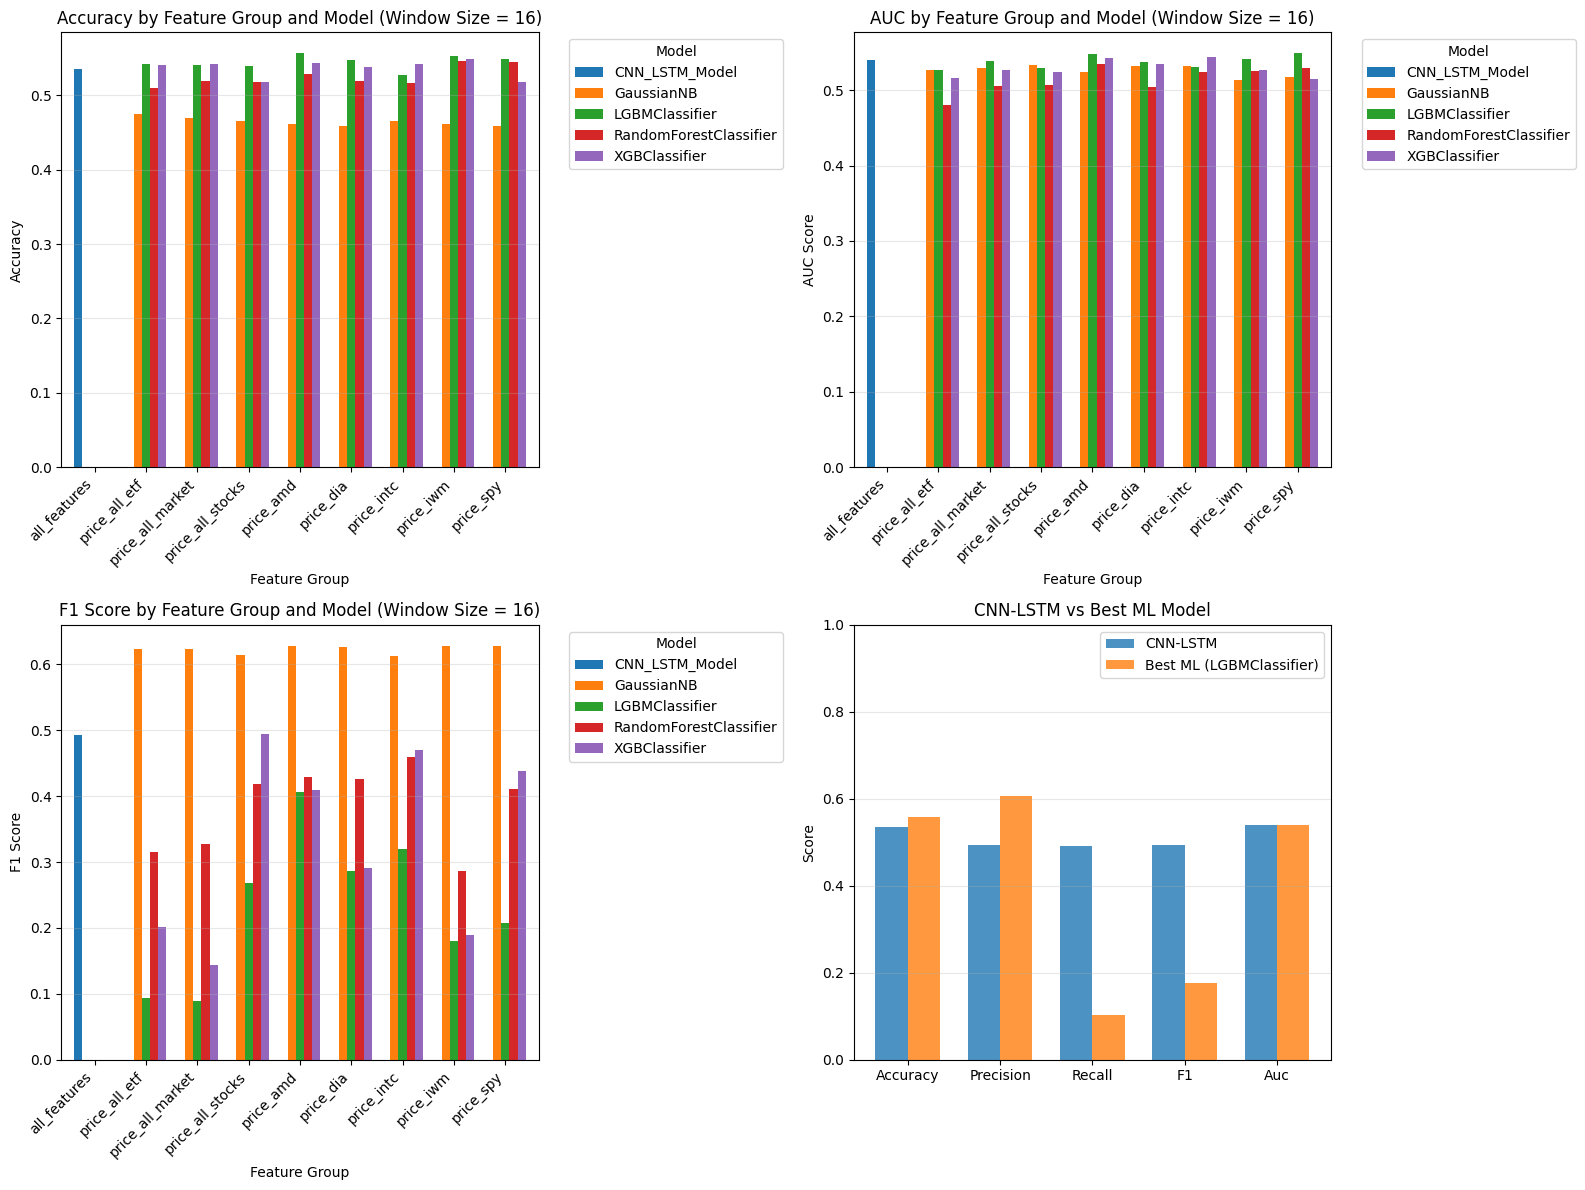


CNN-LSTM Model: CNN_LSTM_Model
  Window Size: 16, Feature Group: all_features
  Accuracy: 0.5356, F1: 0.4931, AUC: 0.5402

Best ML Model: LGBMClassifier
  Window Size: 32, Feature Group: price_iwm
  Accuracy: 0.5572, F1: 0.1755, AUC: 0.5388


In [94]:
# Plot comparison: Accuracy by Model Type
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison for window_size=16
df_ws16 = df_comparison[df_comparison["window"] == 16]
ax1 = axes[0, 0]
pivot = df_ws16.pivot_table(index="col_group", columns="model", values="accuracy")
pivot.plot(kind="bar", ax=ax1, width=0.8)
ax1.set_title("Accuracy by Feature Group and Model (Window Size = 16)")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Feature Group")
ax1.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
ax1.grid(axis="y", alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right")

# 2. AUC comparison for window_size=16
ax2 = axes[0, 1]
pivot_auc = df_ws16.pivot_table(index="col_group", columns="model", values="auc")
pivot_auc.plot(kind="bar", ax=ax2, width=0.8)
ax2.set_title("AUC by Feature Group and Model (Window Size = 16)")
ax2.set_ylabel("AUC Score")
ax2.set_xlabel("Feature Group")
ax2.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
ax2.grid(axis="y", alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha="right")

# 3. F1 Score comparison for window_size=16
ax3 = axes[1, 0]
pivot_f1 = df_ws16.pivot_table(index="col_group", columns="model", values="f1")
pivot_f1.plot(kind="bar", ax=ax3, width=0.8)
ax3.set_title("F1 Score by Feature Group and Model (Window Size = 16)")
ax3.set_ylabel("F1 Score")
ax3.set_xlabel("Feature Group")
ax3.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
ax3.grid(axis="y", alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha="right")

# 4. Model performance comparison (all metrics)
ax4 = axes[1, 1]
cnn_lstm_metrics = df_comparison[df_comparison["model"] == "CNN_LSTM_Model"].iloc[0]
ml_best = df_comparison[df_comparison["model"] != "CNN_LSTM_Model"].sort_values("accuracy", ascending=False).iloc[0]

metrics_to_plot = ["accuracy", "precision", "recall", "f1", "auc"]
cnn_values = [cnn_lstm_metrics[m] for m in metrics_to_plot]
ml_values = [ml_best[m] for m in metrics_to_plot]

x_pos = np.arange(len(metrics_to_plot))
width = 0.35

ax4.bar(x_pos - width / 2, cnn_values, width, label="CNN-LSTM", alpha=0.8)
ax4.bar(x_pos + width / 2, ml_values, width, label=f"Best ML ({ml_best['model']})", alpha=0.8)

ax4.set_ylabel("Score")
ax4.set_title("CNN-LSTM vs Best ML Model")
ax4.set_xticks(x_pos)
ax4.set_xticklabels([m.capitalize() for m in metrics_to_plot])
ax4.legend()
ax4.grid(axis="y", alpha=0.3)
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print(f"\nCNN-LSTM Model: {cnn_lstm_metrics['model']}")
print(f"  Window Size: {cnn_lstm_metrics['window']}, Feature Group: {cnn_lstm_metrics['col_group']}")
print(
    f"  Accuracy: {cnn_lstm_metrics['accuracy']:.4f}, F1: {cnn_lstm_metrics['f1']:.4f}, AUC: {cnn_lstm_metrics['auc']:.4f}"
)
print(f"\nBest ML Model: {ml_best['model']}")
print(f"  Window Size: {ml_best['window']}, Feature Group: {ml_best['col_group']}")
print(f"  Accuracy: {ml_best['accuracy']:.4f}, F1: {ml_best['f1']:.4f}, AUC: {ml_best['auc']:.4f}")